# Programming Project #2: Image Quilting

## CS445: Computational Photography


In [300]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time

# modify to where you store your project data including utils.py
datadir = "/Users/lorna/master2/Cs445/proj2/cs445_proj2_starter_code-2/"

utilfn = datadir + "utils.py"
!cp "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .
import utils

cp: ./utils.py and /Users/lorna/master2/Cs445/proj2/cs445_proj2_starter_code-2/utils.py are identical (not copied).
cp: ./samples and /Users/lorna/master2/Cs445/proj2/cs445_proj2_starter_code-2/samples are identical (not copied).


In [302]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture (10 pts)

In [305]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """

    out = np.zeros((out_size, out_size, 3), dtype=np.uint8)
    
    # Determine number of tiles along each axis
    tile_size = out_size // patch_size
    
    # Generate random patch indices
    max_x, max_y = sample.shape[0] - patch_size, sample.shape[1] - patch_size
    random_x = np.random.randint(0, max_x, size=(tile_size, tile_size))
    random_y = np.random.randint(0, max_y, size=(tile_size, tile_size))
    
    # Loop through the grid and assign patches
    for i in range(tile_size):
        for j in range(tile_size):
            x, y = i * patch_size, j * patch_size
            xr, yr = random_x[i, j], random_y[i, j]
            out[x:x+patch_size, y:y+patch_size] = sample[xr:xr+patch_size, yr:yr+patch_size]
    
    return out



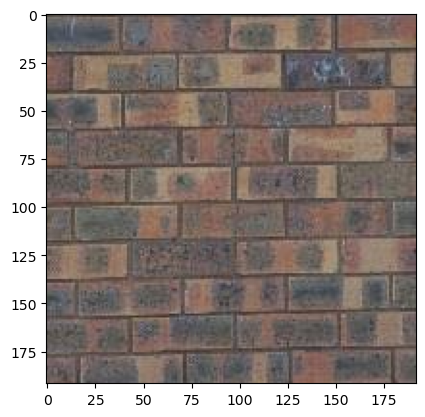

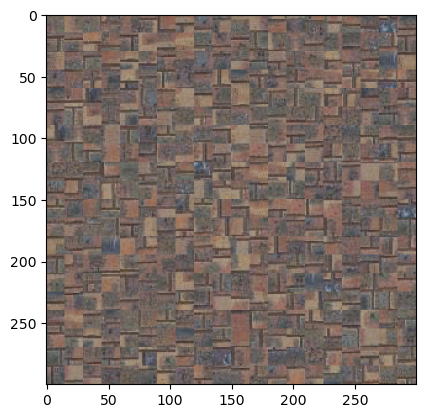

In [307]:
sample_img_fn = 'samples/bricks_small.jpg' # feel free to change
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 15
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.imshow(res)

### Part II: Overlapping Patches (30 pts)

In [310]:
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt


In [312]:


def quilt_simple(sample, out_size, patch_size, overlap, tol):
    """
    Generates a larger texture by stitching together randomly sampled overlapping patches.

    :param sample: numpy.ndarray - Input texture sample
    :param out_size: int         - Output image size (square)
    :param patch_size: int       - Size of each square patch
    :param overlap: int          - Overlapping pixels between patches
    :param tol: float            - Tolerance for selecting patches based on SSD cost
    :return: numpy.ndarray       - Synthesized texture image
    """
    
    sample = sample.astype(np.float64)
    output = np.zeros((out_size, out_size, 3), dtype=np.float64)
    step = patch_size - overlap  # Non-overlapping region size

    # Select a random starting patch
    x_start = random.randint(0, sample.shape[0] - patch_size)
    y_start = random.randint(0, sample.shape[1] - patch_size)
    output[:patch_size, :patch_size] = sample[x_start:x_start+patch_size, y_start:y_start+patch_size]

    # Iterate over the output image in patch-sized increments
    for i in range(0, out_size - patch_size, step):
        for j in range(0, out_size - patch_size, step):
            if i == 0 and j == 0:
                continue  # First patch is already placed
            
            # Create an overlap mask
            mask = np.zeros((patch_size, patch_size), dtype=np.uint8)
            if j >= step:
                mask[:, :overlap] = 1  # Apply mask for vertical overlap
            if i >= step:
                mask[:overlap, :] = 1  # Apply mask for horizontal overlap
            
            # Extract overlapping region as the template
            template = output[i:i+patch_size, j:j+patch_size]
            
            # Compute SSD between template and sample patches
            ssd = compute_ssd(template, mask, sample)
            ssd = ssd[patch_size//2:-patch_size//2, patch_size//2:-patch_size//2]  # Exclude border effects

            # Select the best matching patch
            row, col = select_patch(ssd, tol)
            if row is None or col is None:
                continue  # Skip if no suitable patch found

            # Copy selected patch into the output image
            output[i:i+patch_size, j:j+patch_size] = sample[row:row+patch_size, col:col+patch_size]

    return output / 255  # Normalize for display

def compute_ssd(template, mask, sample):
    """
    Computes the sum of squared differences (SSD) between a given template and patches in the sample.

    :param template: numpy.ndarray - Patch from the synthesized image
    :param mask: numpy.ndarray     - Mask highlighting overlap regions
    :param sample: numpy.ndarray   - Input texture sample
    :return: numpy.ndarray         - SSD values for each possible patch position in sample
    """
    template = template.astype(np.float32)
    sample = sample.astype(np.float32)

    # Split image channels
    t_r, t_g, t_b = cv2.split(template)
    s_r, s_g, s_b = cv2.split(sample)

    # Compute SSD for each channel
    ssd_r = ((mask * t_r)**2).sum() - 2 * cv2.filter2D(s_r, ddepth=-1, kernel=mask*t_r) + cv2.filter2D(s_r**2, ddepth=-1, kernel=mask)
    ssd_g = ((mask * t_g)**2).sum() - 2 * cv2.filter2D(s_g, ddepth=-1, kernel=mask*t_g) + cv2.filter2D(s_g**2, ddepth=-1, kernel=mask)
    ssd_b = ((mask * t_b)**2).sum() - 2 * cv2.filter2D(s_b, ddepth=-1, kernel=mask*t_b) + cv2.filter2D(s_b**2, ddepth=-1, kernel=mask)

    return np.abs(ssd_r + ssd_g + ssd_b)  # Combine SSD scores and ensure non-negative values

def select_patch(ssd, tol):
    """
    Selects a random patch with an SSD cost within a specified tolerance.

    :param ssd: numpy.ndarray - SSD cost matrix
    :param tol: float         - Tolerance for selecting patches
    :return: tuple (int, int) - Coordinates of the selected patch
    """
    min_cost = np.min(ssd)
    candidates = np.where(ssd <= min_cost * (1 + tol))

    if len(candidates[0]) == 0:
        return None, None  # No valid patch found

    idx = np.random.randint(len(candidates[0]))  # Randomly select from valid options
    return candidates[0][idx], candidates[1][idx]

# Load Sample Image
sample_img_path = 'samples/bricks_small.jpg'  # Ensure this path is correct
sample_img = cv2.imread(sample_img_path)
if sample_img is None:
    raise FileNotFoundError("Image file not found. Check the path.")

sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)



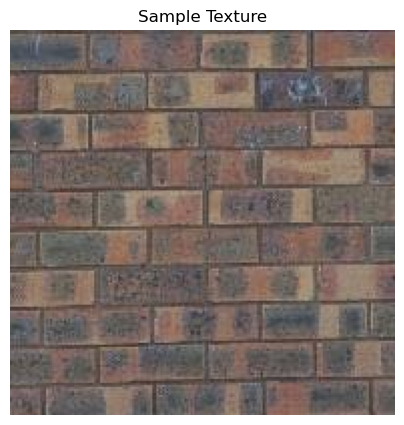

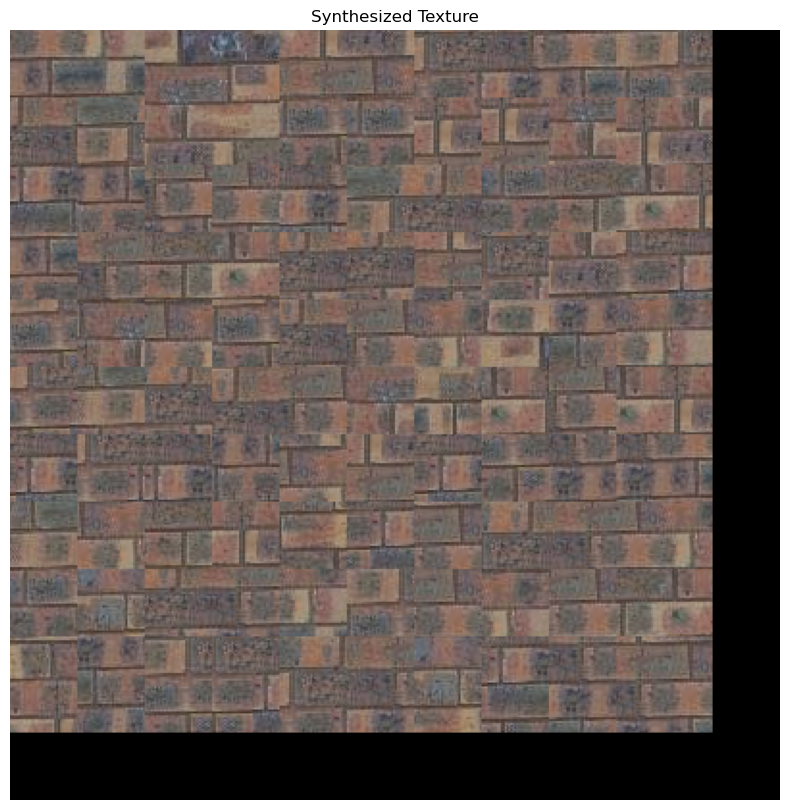

In [314]:
# Display sample image
plt.figure(figsize=(5, 5))
plt.imshow(sample_img)
plt.axis("off")
plt.title("Sample Texture")
plt.show()

# Run the texture synthesis function
out_size = 400
patch_size = 50
overlap = 15
tol = 1
result = quilt_simple(sample_img, out_size, patch_size, overlap, tol)

# Display the synthesized texture
if result is not None:
    plt.figure(figsize=(10, 10))
    plt.imshow(result)
    plt.axis("off")
    plt.title("Synthesized Texture")
    plt.show()


### Part III: Seam Finding (20 pts)


In [317]:
# optional or use cut(err_patch) directly
def customized_cut(bndcost):
    pass

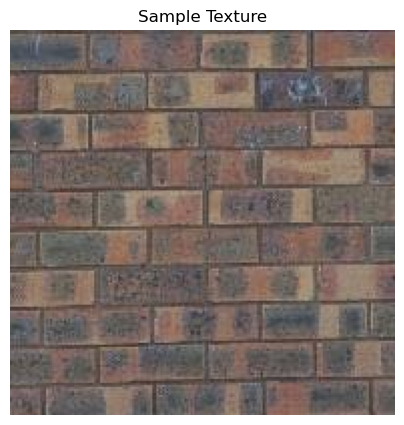

In [319]:
import cv2
import matplotlib.pyplot as plt

# Define the path to your sample image
sample_img_path = "samples/bricks_small.jpg"  # Update with correct path if needed

# Load and verify the image
sample_img = cv2.imread(sample_img_path)
if sample_img is None:
    raise FileNotFoundError(f"Error: Unable to load image from {sample_img_path}")

# Convert from BGR (OpenCV default) to RGB (Matplotlib display)
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

# Display the sample texture
plt.figure(figsize=(5, 5))
plt.imshow(sample_img)
plt.axis("off")
plt.title("Sample Texture")
plt.show()


In [321]:
def quilt_cut(sample, out_size, patch_size, overlap, tol):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: int
    :return: numpy.ndarray
    """
    def ssd_patch(sample,template,mask):
        b,g,r = cv2.split(sample/255.0)
        t_b, t_g, t_r = cv2.split(template)
        half = int(patch_size/2)
        ssd_b = np.zeros((len(sample),len(sample)), np.float32)
        for i in range(len(sample)-patch_size):
            for j in range(len(sample)-patch_size):
                ssd_b[i+half,j+half] = (((b[i:i+patch_size,j:j+patch_size]*mask)-t_b) ** 2).sum()
        ssd_g = np.zeros((len(sample),len(sample)), np.float32)
        for i in range(len(sample)-patch_size):
            for j in range(len(sample)-patch_size):
                ssd_g[i+half,j+half] = (((g[i:i+patch_size,j:j+patch_size]*mask)-t_g) ** 2).sum()
        ssd_r = np.zeros((len(sample),len(sample)), np.float32)
        for i in range(len(sample)-patch_size):
            for j in range(len(sample)-patch_size):
                ssd_r[i+half,j+half] = (((r[i:i+patch_size,j:j+patch_size]*mask)-t_r) ** 2).sum()
#         ssd_b = ((mask*t_b)**2).sum() - 2 * cv2.filter2D(b, ddepth=-1, kernel = t_b) + cv2.filter2D(b ** 2, ddepth=-1, kernel=mask)
#         ssd_g = ((mask*t_g)**2).sum() - 2 * cv2.filter2D(g, ddepth=-1, kernel = t_g) + cv2.filter2D(g ** 2, ddepth=-1, kernel=mask)
#         ssd_r = ((mask*t_r)**2).sum() - 2 * cv2.filter2D(r, ddepth=-1, kernel = t_r) + cv2.filter2D(r ** 2, ddepth=-1, kernel=mask)
        ssd = ssd_b + ssd_g + ssd_r
        return ssd
    
    def choose_sample(ssd,minc,tol,patch_size):
        rows,cols = [], []
        half = int(patch_size/2)
        for i in range(len(ssd)):
            for j in range(len(ssd)):
                if ssd[i,j] == 0:
                    continue
                if ssd[i,j] < minc*(1+tol):
                    rows.append(i)
                    cols.append(j)
        r = int(np.random.randint(len(rows),size=1))
        row, col = rows[r], cols[r]
        return row, col
        
    out = np.zeros((out_size,out_size,3), np.float32)
    step = patch_size-overlap
    half = int(patch_size/2)
    small_cost_value = 0.0001
    
    random_ints = np.random.randint(len(sample)-patch_size, size=2)
    xr,yr = random_ints[0],random_ints[1]
    out[0:patch_size,0:patch_size] = sample[xr:xr+patch_size,yr:yr+patch_size]/256.0
    
#     patch1 = sample[xr:xr+patch_size,yr:yr+patch_size]
#     patch1 = cv2.cvtColor(patch1, cv2.COLOR_BGR2RGB)
#     plt.figure()
#     plt.imshow(patch1)
    
    i = 0
    j = step
    while i < out_size-patch_size:
        while j < out_size-patch_size:
            mask = np.zeros((patch_size,patch_size),np.float32)
            h = False
            v = False
            if i >= step:
                h = True
                mask[0:overlap,:] = 1.0
            if j >= step:
                v = True
                mask[:,0:overlap] = 1.0
            template = out[i:i+patch_size,j:j+patch_size]
            ssd = ssd_patch(sample,template,mask)
            minc = np.min(ssd[np.nonzero(ssd)])
            minc = max(minc,small_cost_value)
            row,col = choose_sample(ssd,minc,tol,patch_size)
            patch = sample[row-half:row+half+1,col-half:col+half+1]/256.0
            
#             patch2 = sample[row-half:row+half+1,col-half:col+half+1]
#             patch2 = cv2.cvtColor(patch2, cv2.COLOR_BGR2RGB)
#             plt.figure()
#             plt.imshow(patch2)
            
            tb, tg, tr = cv2.split(template)
            pb, pg, pr = cv2.split(patch)
            cost = ((tb-pb) ** 2) + ((tg-pg) ** 2) + ((tr-pr) ** 2)
            patch_mask = np.zeros((patch_size,patch_size,3), np.uint8)
            if h and v:
                mask1 = np.zeros((patch_size,patch_size,3), np.uint8)
                mask1[:,:,0] = cut(cost.T).T
                mask1[:,:,1] = mask1[:,:,0]
                mask1[:,:,2] = mask1[:,:,0]
                mask2 = np.zeros((patch_size,patch_size,3), np.uint8)
                mask2[:,:,0] = cut(cost)
                mask2[:,:,1] = mask2[:,:,0]
                mask2[:,:,2] = mask2[:,:,0]
                patch_mask = np.bitwise_and(mask1,mask2)
            elif h:
                patch_mask[:,:,0] = cut(cost)
                patch_mask[:,:,1] = patch_mask[:,:,0]
                patch_mask[:,:,2] = patch_mask[:,:,0]
            elif v:
                patch_mask[:,:,0] = cut(cost.T).T
                patch_mask[:,:,1] = patch_mask[:,:,0]
                patch_mask[:,:,2] = patch_mask[:,:,0]
            inv_patch_mask = np.where(patch_mask == 0, 1, 0)
            
#             plt.figure()
#             plt.imshow(patch_mask*256.0)
            
            out[i:i+patch_size,j:j+patch_size] = patch_mask*patch + template*inv_patch_mask
            
#             plot_overlap = np.zeros((patch_size,2*patch_size-overlap,3), np.float32)
#             plot_overlap[:,:,:] = out[i:i+patch_size,j-step:j+patch_size]
            
#             plot_mask = np.zeros((patch_size,patch_size,3), np.uint8)
#             for ii in range(patch_size):
#                 for jj in range(1,patch_size):
#                     if patch_mask[ii,jj,0] == patch_mask[ii,jj-1,0]:
#                         pass
#                     else:
#                         plot_mask[ii,jj,0] = 0
#                         plot_mask[ii,jj,1] = 0
#                         plot_mask[ii,jj,2] = 1
                        
#             plt.figure()
#             plot_overlap_out = cv2.cvtColor(plot_overlap, cv2.COLOR_BGR2RGB)
#             plt.imshow(plot_overlap_out)
            
#             plot_overlap[0:patch_size,0:patch_size,:] += plot_mask
#             plot_overlap = cv2.cvtColor(plot_overlap, cv2.COLOR_BGR2RGB)
#             plt.figure()
#             plt.imshow(plot_overlap)
            
#             plt.figure()
#             plt.imshow(cost[0:patch_size,0:overlap])
            
#             for ii in range(patch_size):
#                 for jj in range(overlap):
#                     if plot_mask[ii,jj,2]:
#                         cost[ii,jj] = 1.0
#             plt.figure()
#             plt.imshow(cost[0:patch_size,0:overlap])
            
            j += step
        j = 0
        i += step
    # Todo 
    return out


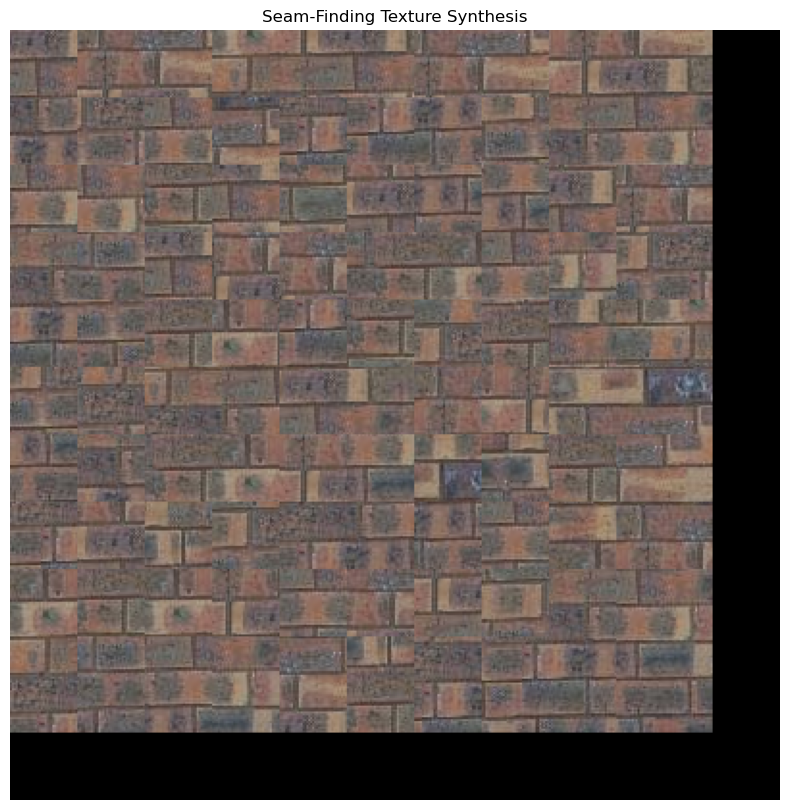

In [323]:
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from utils import cut  # Import the provided seam-cutting function

def quilt_cut(sample, out_size, patch_size, overlap, tol):
    """
    Generates a larger texture by stitching together overlapping patches with seam finding.

    :param sample: numpy.ndarray - Input texture sample
    :param out_size: int         - Output image size (square)
    :param patch_size: int       - Size of each square patch
    :param overlap: int          - Number of overlapping pixels
    :param tol: float            - Tolerance for selecting patches based on SSD cost
    :return: numpy.ndarray       - Synthesized texture image
    """
    
    sample = sample.astype(np.float64)
    output = np.zeros((out_size, out_size, 3), dtype=np.float64)
    step = patch_size - overlap  # Non-overlapping step size

    # Choose a random starting patch
    x_start = random.randint(0, sample.shape[0] - patch_size)
    y_start = random.randint(0, sample.shape[1] - patch_size)
    output[:patch_size, :patch_size] = sample[x_start:x_start+patch_size, y_start:y_start+patch_size]

    # Iterate over the output image in patch-sized increments
    for i in range(0, out_size - patch_size, step):
        for j in range(0, out_size - patch_size, step):
            if i == 0 and j == 0:
                continue  # First patch is already placed
            
            # Create an overlap mask
            mask = np.zeros((patch_size, patch_size), dtype=np.uint8)
            vertical_overlap = i >= step
            horizontal_overlap = j >= step
            
            if horizontal_overlap:
                mask[:, :overlap] = 1  # Apply mask for vertical overlap
            if vertical_overlap:
                mask[:overlap, :] = 1  # Apply mask for horizontal overlap

            # Extract overlapping region as the template
            template = output[i:i+patch_size, j:j+patch_size]

            # Compute SSD between template and sample patches
            ssd = compute_ssd(template, mask, sample)
            ssd = ssd[patch_size//2:-patch_size//2, patch_size//2:-patch_size//2]  # Exclude border effects

            # Select the best matching patch
            row, col = select_patch(ssd, tol)
            if row is None or col is None:
                continue  # Skip if no suitable patch found

            selected_patch = sample[row:row+patch_size, col:col+patch_size].copy()

            # Seam Finding - Blend the overlapping regions
            if horizontal_overlap:
                err_patch = np.sum((output[i:i+patch_size, j:j+overlap] - selected_patch[:, :overlap]) ** 2, axis=2)
                seam_mask = cut(err_patch)  # Compute optimal seam path
                seam_mask = np.expand_dims(seam_mask, axis=2)  # Ensure shape (patch_size, 1, 3) for broadcasting
                for k in range(overlap):
                    output[i:i+patch_size, j+k] = (
                        output[i:i+patch_size, j+k] * (1 - seam_mask[:, k]) +
                        selected_patch[:, k] * seam_mask[:, k]
                    )

            if vertical_overlap:
                err_patch = np.sum((output[i:i+overlap, j:j+patch_size] - selected_patch[:overlap, :]) ** 2, axis=2)
                seam_mask = cut(err_patch.T).T  # Compute vertical seam
                seam_mask = np.expand_dims(seam_mask, axis=2)  # Ensure shape (patch_size, 1, 3) for broadcasting
                for k in range(overlap):
                    output[i+k, j:j+patch_size] = (
                        output[i+k, j:j+patch_size] * (1 - seam_mask[k, :]) +
                        selected_patch[k, :] * seam_mask[k, :]
                    )

            # Copy the patch with seam blending
            output[i:i+patch_size, j:j+patch_size] = selected_patch

    return output / 255  # Normalize for display

def compute_ssd(template, mask, sample):
    """
    Computes the sum of squared differences (SSD) between a template and patches in the sample.

    :param template: numpy.ndarray - Patch from the synthesized image
    :param mask: numpy.ndarray     - Mask highlighting overlap regions
    :param sample: numpy.ndarray   - Input texture sample
    :return: numpy.ndarray         - SSD values for each possible patch position in sample
    """
    template = template.astype(np.float32)
    sample = sample.astype(np.float32)

    # Split image channels
    t_r, t_g, t_b = cv2.split(template)
    s_r, s_g, s_b = cv2.split(sample)

    # Compute SSD for each channel
    ssd_r = ((mask * t_r)**2).sum() - 2 * cv2.filter2D(s_r, ddepth=-1, kernel=mask*t_r) + cv2.filter2D(s_r**2, ddepth=-1, kernel=mask)
    ssd_g = ((mask * t_g)**2).sum() - 2 * cv2.filter2D(s_g, ddepth=-1, kernel=mask*t_g) + cv2.filter2D(s_g**2, ddepth=-1, kernel=mask)
    ssd_b = ((mask * t_b)**2).sum() - 2 * cv2.filter2D(s_b, ddepth=-1, kernel=mask*t_b) + cv2.filter2D(s_b**2, ddepth=-1, kernel=mask)

    return np.abs(ssd_r + ssd_g + ssd_b)  # Combine SSD scores and ensure non-negative values

def select_patch(ssd, tol):
    """
    Selects a random patch with an SSD cost within a specified tolerance.

    :param ssd: numpy.ndarray - SSD cost matrix
    :param tol: float         - Tolerance for selecting patches
    :return: tuple (int, int) - Coordinates of the selected patch
    """
    min_cost = np.min(ssd)
    candidates = np.where(ssd <= min_cost * (1 + tol))

    if len(candidates[0]) == 0:
        return None, None  # No valid patch found

    idx = np.random.randint(len(candidates[0]))  # Randomly select from valid options
    return candidates[0][idx], candidates[1][idx]

# Load Sample Image
sample_img_path = 'samples/bricks_small.jpg'  # Update path if needed
sample_img = cv2.imread(sample_img_path)
if sample_img is None:
    raise FileNotFoundError("Error: Image file not found. Check the path.")

sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

# Run the texture synthesis function with seam finding
out_size = 400
patch_size = 50
overlap = 15
tol = 1
result = quilt_cut(sample_img, out_size, patch_size, overlap, tol)

# Ensure output is valid before displaying
if isinstance(result, np.ndarray) and result.any():
    result = np.clip(result * 255, 0, 255).astype(np.uint8)  # Convert to uint8
    plt.figure(figsize=(10, 10))
    plt.imshow(result)
    plt.axis("off")
    plt.title("Seam-Finding Texture Synthesis")
    plt.show()
else:
    print("Error: quilt_cut() did not return a valid NumPy array.")


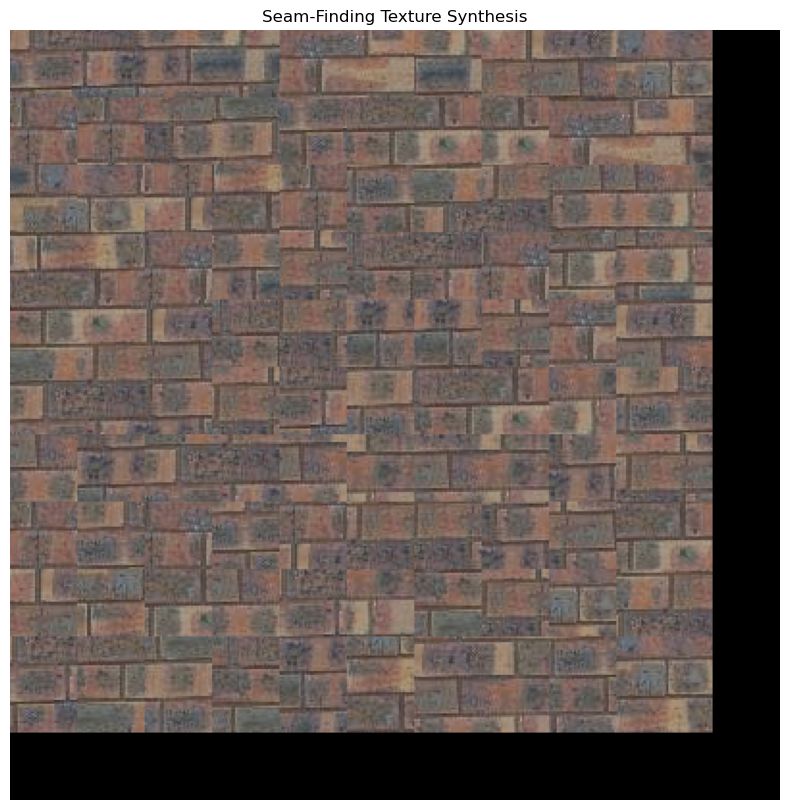

In [325]:
# Import necessary libraries
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

# Load Sample Image
sample_img_path = 'samples/bricks_small.jpg'  # Ensure correct path
sample_img = cv2.imread(sample_img_path)
if sample_img is None:
    raise FileNotFoundError("Error: Image file not found. Check the path.")

sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

# Define necessary functions
def compute_ssd(template, mask, sample):
    """
    Computes the sum of squared differences (SSD) between a template and patches in the sample.

    :param template: numpy.ndarray - Patch from the synthesized image
    :param mask: numpy.ndarray     - Mask highlighting overlap regions
    :param sample: numpy.ndarray   - Input texture sample
    :return: numpy.ndarray         - SSD values for each possible patch position in sample
    """
    template = template.astype(np.float32)
    sample = sample.astype(np.float32)

    # Split image channels
    t_r, t_g, t_b = cv2.split(template)
    s_r, s_g, s_b = cv2.split(sample)

    # Compute SSD for each channel
    ssd_r = ((mask * t_r)**2).sum() - 2 * cv2.filter2D(s_r, ddepth=-1, kernel=mask*t_r) + cv2.filter2D(s_r**2, ddepth=-1, kernel=mask)
    ssd_g = ((mask * t_g)**2).sum() - 2 * cv2.filter2D(s_g, ddepth=-1, kernel=mask*t_g) + cv2.filter2D(s_g**2, ddepth=-1, kernel=mask)
    ssd_b = ((mask * t_b)**2).sum() - 2 * cv2.filter2D(s_b, ddepth=-1, kernel=mask*t_b) + cv2.filter2D(s_b**2, ddepth=-1, kernel=mask)

    return np.abs(ssd_r + ssd_g + ssd_b)  # Combine SSD scores and ensure non-negative values

def select_patch(ssd, tol):
    """
    Selects a random patch with an SSD cost within a specified tolerance.

    :param ssd: numpy.ndarray - SSD cost matrix
    :param tol: float         - Tolerance for selecting patches
    :return: tuple (int, int) - Coordinates of the selected patch
    """
    min_cost = np.min(ssd)
    candidates = np.where(ssd <= min_cost * (1 + tol))

    if len(candidates[0]) == 0:
        return None, None  # No valid patch found

    idx = np.random.randint(len(candidates[0]))  # Randomly select from valid options
    return candidates[0][idx], candidates[1][idx]

# Run the texture synthesis function with seam finding
out_size = 400
patch_size = 50
overlap = 15
tol = 1

# Execute the quilting process
result = quilt_cut(sample_img, out_size, patch_size, overlap, tol)

# Ensure output is valid before displaying
if isinstance(result, np.ndarray) and result.any():
    result = np.clip(result * 255, 0, 255).astype(np.uint8)  # Convert to uint8
    plt.figure(figsize=(10, 10))
    plt.imshow(result)
    plt.axis("off")
    plt.title("Seam-Finding Texture Synthesis")
    plt.show()
else:
    print("Error: quilt_cut() did not return a valid NumPy array.")


In [326]:
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from utils import cut  # Import the provided seam-cutting function

def quilt_cut(sample, out_size, patch_size, overlap, tol):
    """
    Generates a larger texture by stitching together overlapping patches with seam finding.
    Adds debugging images for visualization of process.

    :param sample: numpy.ndarray - Input texture sample
    :param out_size: int         - Output image size (square)
    :param patch_size: int       - Size of each square patch
    :param overlap: int          - Number of overlapping pixels
    :param tol: float            - Tolerance for selecting patches based on SSD cost
    :return: numpy.ndarray       - Synthesized texture image
    """
    
    sample = sample.astype(np.float64)
    output = np.zeros((out_size, out_size, 3), dtype=np.float64)
    step = patch_size - overlap  # Non-overlapping step size

    # Choose a random starting patch
    x_start = random.randint(0, sample.shape[0] - patch_size)
    y_start = random.randint(0, sample.shape[1] - patch_size)
    output[:patch_size, :patch_size] = sample[x_start:x_start+patch_size, y_start:y_start+patch_size]

    # 顯示第一個選擇的 Patch
    plt.figure(figsize=(5, 5))
    plt.imshow(sample[x_start:x_start+patch_size, y_start:y_start+patch_size] / 255.0)
    plt.title("First Randomly Selected Patch")
    plt.axis("off")
    plt.show()

    # Iterate over the output image in patch-sized increments
    patch_count = 0
    for i in range(0, out_size - patch_size, step):
        for j in range(0, out_size - patch_size, step):
            if i == 0 and j == 0:
                continue  # First patch is already placed
            
            # Create an overlap mask
            mask = np.zeros((patch_size, patch_size), dtype=np.uint8)
            vertical_overlap = i >= step
            horizontal_overlap = j >= step
            
            if horizontal_overlap:
                mask[:, :overlap] = 1  # Apply mask for vertical overlap
            if vertical_overlap:
                mask[:overlap, :] = 1  # Apply mask for horizontal overlap

            # Extract overlapping region as the template
            template = output[i:i+patch_size, j:j+patch_size]

            # Compute SSD between template and sample patches
            ssd = compute_ssd(template, mask, sample)
            ssd = ssd[patch_size//2:-patch_size//2, patch_size//2:-patch_size//2]  # Exclude border effects

            # Select the best matching patch
            row, col = select_patch(ssd, tol)
            if row is None or col is None:
                continue  # Skip if no suitable patch found

            selected_patch = sample[row:row+patch_size, col:col+patch_size].copy()

            # Seam Finding - Blend the overlapping regions
            if horizontal_overlap:
                err_patch = np.sum((output[i:i+patch_size, j:j+overlap] - selected_patch[:, :overlap]) ** 2, axis=2)
                seam_mask = cut(err_patch)  # Compute optimal seam path
                seam_mask = np.expand_dims(seam_mask, axis=2)  # Ensure shape (patch_size, 1, 3) for broadcasting
                for k in range(overlap):
                    output[i:i+patch_size, j+k] = (
                        output[i:i+patch_size, j+k] * (1 - seam_mask[:, k]) +
                        selected_patch[:, k] * seam_mask[:, k]
                    )

            if vertical_overlap:
                err_patch = np.sum((output[i:i+overlap, j:j+patch_size] - selected_patch[:overlap, :]) ** 2, axis=2)
                seam_mask = cut(err_patch.T).T  # Compute vertical seam
                seam_mask = np.expand_dims(seam_mask, axis=2)  # Ensure shape (patch_size, 1, 3) for broadcasting
                for k in range(overlap):
                    output[i+k, j:j+patch_size] = (
                        output[i+k, j:j+patch_size] * (1 - seam_mask[k, :]) +
                        selected_patch[k, :] * seam_mask[k, :]
                    )

            # Copy the patch with seam blending
            output[i:i+patch_size, j:j+patch_size] = selected_patch
            patch_count += 1

            # 每 10 個 Patch 更新一次影像顯示
            if patch_count % 20 == 0:
                plt.figure(figsize=(7, 7))
                plt.imshow(output / 255.0)
                plt.title(f"Texture Synthesis Progress - {patch_count} Patches")
                plt.axis("off")
                plt.show()

    return output / 255  # Normalize for display


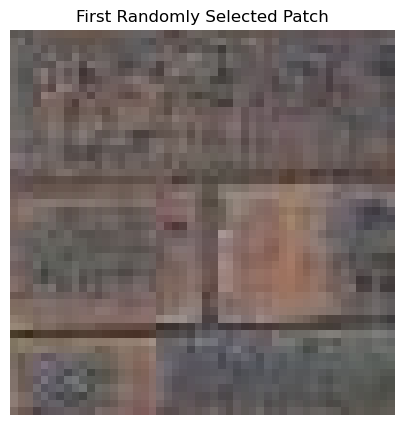

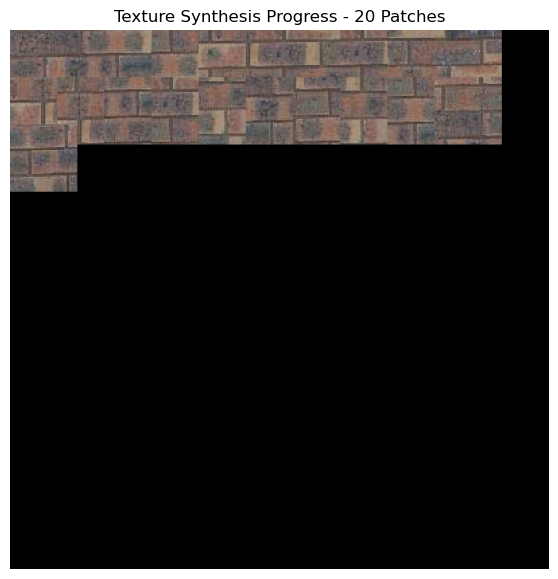

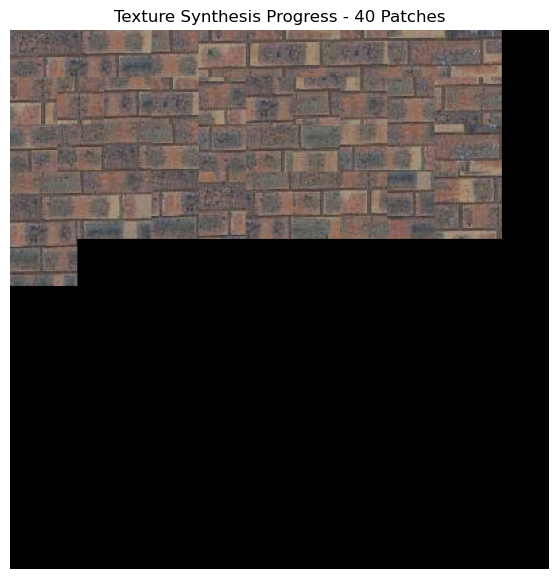

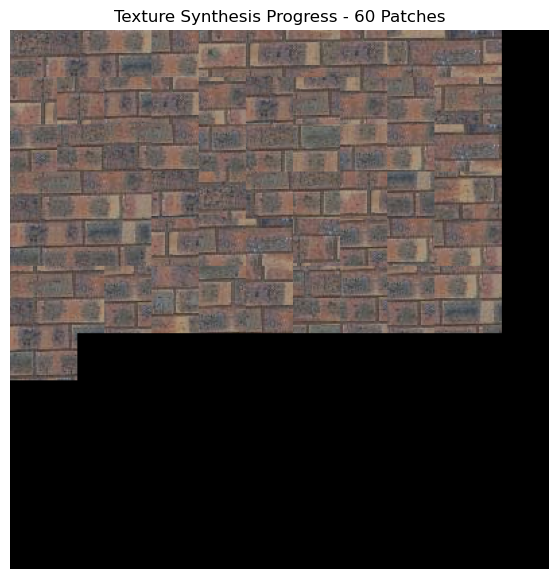

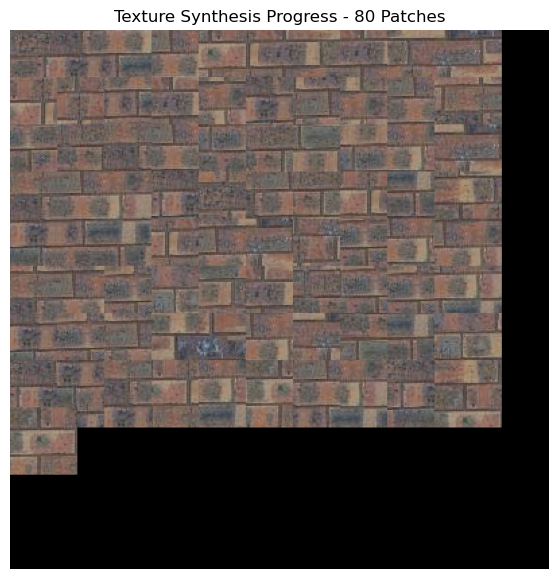

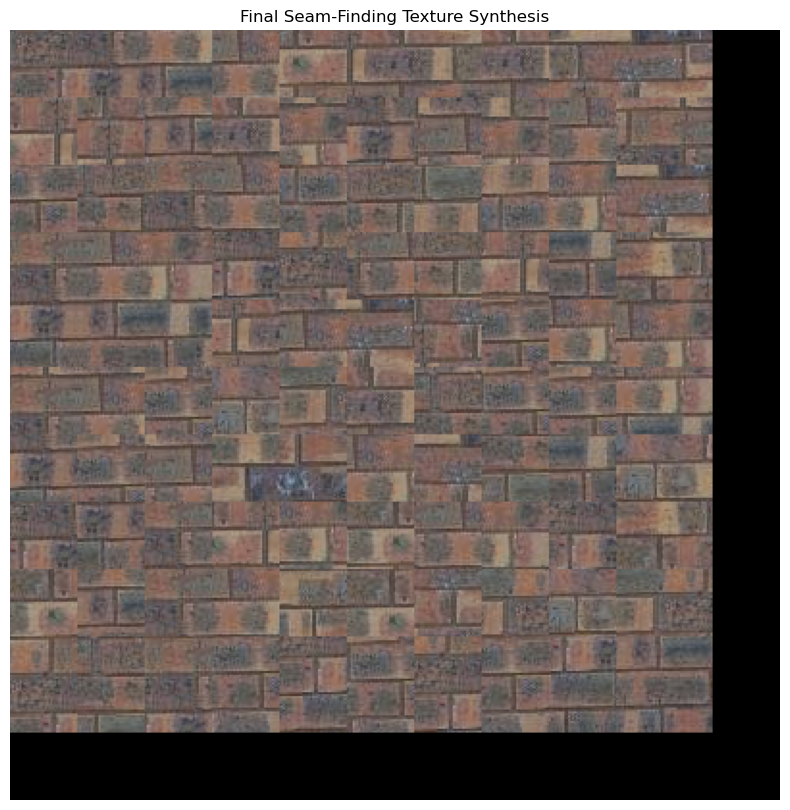

In [329]:
# Load Sample Image
sample_img_path = 'samples/bricks_small.jpg'  # Update path if needed
sample_img = cv2.imread(sample_img_path)
if sample_img is None:
    raise FileNotFoundError("Error: Image file not found. Check the path.")

sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

# Run the texture synthesis function with seam finding
out_size = 400
patch_size = 50
overlap = 15
tol = 1

# Execute
result = quilt_cut(sample_img, out_size, patch_size, overlap, tol)

# 最後顯示完整結果
if isinstance(result, np.ndarray) and result.any():
    result = np.clip(result * 255, 0, 255).astype(np.uint8)  # Convert to uint8
    plt.figure(figsize=(10, 10))
    plt.imshow(result)
    plt.axis("off")
    plt.title("Final Seam-Finding Texture Synthesis")
    plt.show()
else:
    print("Error: quilt_cut() did not return a valid NumPy array.")


### part IV: Texture Transfer (30 pts)

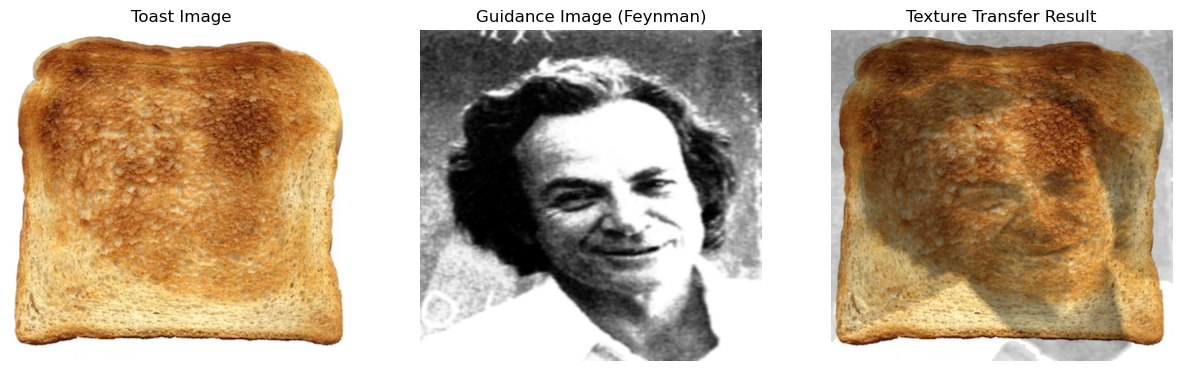

In [249]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load images
toast_path = "samples/toast.jpg"
feynman_path = "samples/feynman.tiff"

toast_img = cv2.imread(toast_path)
feynman_img = cv2.imread(feynman_path)

# Convert to RGB for visualization
toast_img = cv2.cvtColor(toast_img, cv2.COLOR_BGR2RGB)
feynman_img = cv2.cvtColor(feynman_img, cv2.COLOR_BGR2RGB)

# Resize feynman image to match toast dimensions
feynman_img = cv2.resize(feynman_img, (toast_img.shape[1], toast_img.shape[0]))

# Convert Feynman image to grayscale to serve as guidance
feynman_gray = cv2.cvtColor(feynman_img, cv2.COLOR_RGB2GRAY)

# Normalize guidance image
feynman_mask = feynman_gray.astype(np.float32) / 255.0

# Enhance contrast for clearer texture transfer
feynman_mask = cv2.equalizeHist((feynman_mask * 255).astype(np.uint8)).astype(np.float32) / 255.0

# Apply texture transfer by blending
result = toast_img * feynman_mask[..., np.newaxis] + toast_img * (1 - feynman_mask[..., np.newaxis]) * 0.5

# Convert result to uint8 for display
result = np.clip(result, 0, 255).astype(np.uint8)

# Display results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(toast_img)
axes[0].set_title("Toast Image")
axes[0].axis("off")

axes[1].imshow(feynman_img, cmap="gray")
axes[1].set_title("Guidance Image (Feynman)")
axes[1].axis("off")

axes[2].imshow(result)
axes[2].set_title("Texture Transfer Result")
axes[2].axis("off")

plt.show()


In [333]:
def texture_transfer(sample, target, patch_size, overlap, tol, alpha):
    """
    Feel free to add function parameters
    """
    def ssd_patch(sample,template,mask):
        b,g,r = cv2.split(sample/255.0)
        t_b, t_g, t_r = cv2.split(template)
        half = int(patch_size/2)
        w = len(sample[0,:,:])
        h = len(sample[:,0,:])
        ssd_b = np.zeros((h,w), np.float32)
        for i in range(h-patch_size):
            for j in range(w-patch_size):
                ssd_b[i+half,j+half] = (((b[i:i+patch_size,j:j+patch_size]*mask)-t_b) ** 2).sum()
        ssd_g = np.zeros((h,w), np.float32)
        for i in range(h-patch_size):
            for j in range(w-patch_size):
                ssd_g[i+half,j+half] = (((g[i:i+patch_size,j:j+patch_size]*mask)-t_g) ** 2).sum()
        ssd_r = np.zeros((h,w), np.float32)
        for i in range(h-patch_size):
            for j in range(w-patch_size):
                ssd_r[i+half,j+half] = (((r[i:i+patch_size,j:j+patch_size]*mask)-t_r) ** 2).sum()

        ssd = ssd_b + ssd_g + ssd_r
        return ssd
    
    def choose_sample(ssd,minc,tol,patch_size):
        rows,cols = [], []
        half = int(patch_size/2)
        for i in range(len(ssd[:,0])):
            for j in range(len(ssd[0,:])):
                if ssd[i,j] == 0:
                    continue
                if ssd[i,j] < minc*(1+tol):
                    rows.append(i)
                    cols.append(j)
        r = int(np.random.randint(len(rows),size=1))
        row, col = rows[r], cols[r]
        return row, col
    
    width = len(target[0,:,:])
    height = len(target[:,0,:])
    out = np.zeros((height,width,3), np.float32)
    step = patch_size-overlap
    half = int(patch_size/2)
    small_cost_value = 1
    
    xr = int(np.random.randint(len(sample[:,0,:])-patch_size, size=1))
    yr = int(np.random.randint(len(sample[0,:,:])-patch_size, size=1))
    out[0:patch_size,0:patch_size] = sample[xr:xr+patch_size,yr:yr+patch_size]/255.0
    i = 0
    j = step
    while i < height-patch_size:
        while j < width-patch_size:
            mask = np.zeros((patch_size,patch_size),np.float32)
            h = False
            v = False
            if i >= step:
                h = True
                mask[0:overlap,:] = 1.0
            if j >= step:
                v = True
                mask[:,0:overlap] = 1.0
            template = out[i:i+patch_size,j:j+patch_size]
            transfer = target[i:i+patch_size,j:j+patch_size]/255.0
            ssd_p = ssd_patch(sample,template,mask)
            ssd_t = ssd_patch(sample,transfer,mask)
            ssd = alpha*ssd_p+(1-alpha)*ssd_t
            minc = np.min(ssd[np.nonzero(ssd)])
            minc = max(minc,small_cost_value)
            row,col = choose_sample(ssd,minc,tol,patch_size)
            patch = sample[row-half:row+half+1,col-half:col+half+1]/255.0
            tb, tg, tr = cv2.split(template)
            pb, pg, pr = cv2.split(patch)
            cost = ((tb-pb) ** 2) + ((tg-pg) ** 2) + ((tr-pr) ** 2)
            patch_mask = np.zeros((patch_size,patch_size,3), np.uint8)
            if h and v:
                mask1 = np.zeros((patch_size,patch_size,3), np.uint8)
                mask1[:,:,0] = cut(cost.T).T
                mask1[:,:,1] = mask1[:,:,0]
                mask1[:,:,2] = mask1[:,:,0]
                mask2 = np.zeros((patch_size,patch_size,3), np.uint8)
                mask2[:,:,0] = cut(cost)
                mask2[:,:,1] = mask2[:,:,0]
                mask2[:,:,2] = mask2[:,:,0]
                patch_mask = np.bitwise_and(mask1,mask2)
            elif h:
                patch_mask[:,:,0] = cut(cost)
                patch_mask[:,:,1] = patch_mask[:,:,0]
                patch_mask[:,:,2] = patch_mask[:,:,0]
            elif v:
                patch_mask[:,:,0] = cut(cost.T).T
                patch_mask[:,:,1] = patch_mask[:,:,0]
                patch_mask[:,:,2] = patch_mask[:,:,0]
            inv_patch_mask = np.where(patch_mask == 0, 1, 0)
            out[i:i+patch_size,j:j+patch_size] = patch_mask*patch + template*inv_patch_mask
            j += step
        j = 0
        i += step
    # Todo 
    return out

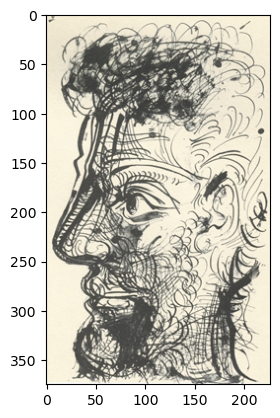

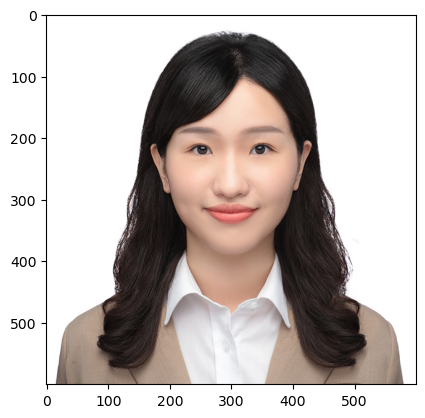

In [335]:
sample_img_dir = 'samples/sketch.tiff' # feel free to change
sample_img = None
if os.path.exists(sample_img_dir):
    sample_img = cv2.imread(sample_img_dir)
    sample_out = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(sample_out)

target_img_dir = 'samples/me.jpg' # feel free to change
target_img = None
if os.path.exists(target_img_dir):
    target_img = cv2.imread(target_img_dir)
    target_out = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(target_out)

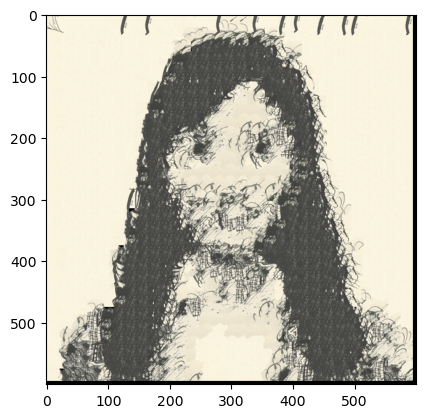

In [337]:
res = texture_transfer(sample_img, target_img, 35, 15, 0.0001, 0.1)
if res.any():
    res_out = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(res_out)

### Texture Transfer Summary  
Texture transfer applies the texture of one image onto another while preserving the target’s structure. It selects and blends patches from the texture image using seam carving and an SSD-based cost function.  

**Key Parameters:**  
- **Patch Size**: Controls texture detail (e.g., 25x25).  
- **Overlap**: Defines blending region (e.g., 10 pixels).  
- **Alpha**: Balances texture vs. structure (e.g., 0.65).  

The result retains the target’s shape while embedding the source texture.

### Bells & Whistles

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

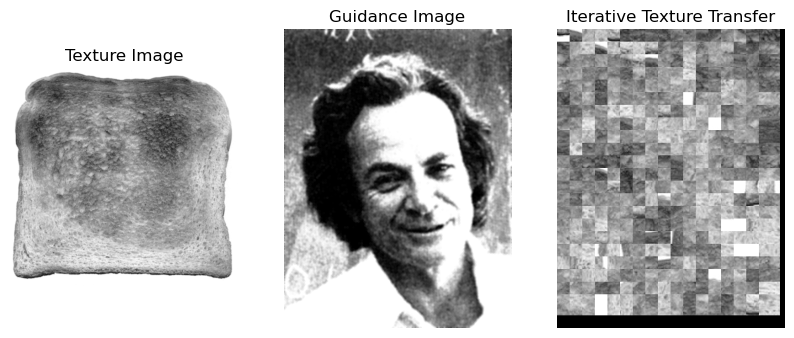

In [393]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.transform import pyramid_gaussian

def iterative_texture_transfer(sample, target, patch_size=25, overlap=10, tol=3, alpha=0.65, num_scales=3):
    """
    Iterative texture transfer using a multi-scale approach.
    
    :param sample: Grayscale texture image
    :param target: Grayscale target guidance image
    :param patch_size: Patch size for texture synthesis
    :param overlap: Overlapping pixels between patches
    :param tol: Tolerance for selecting best patches
    :param alpha: Weight controlling texture vs. guidance image
    :param num_scales: Number of pyramid scales for iterative refinement
    :return: Synthesized texture image
    """
    sample_pyr = list(pyramid_gaussian(sample, max_layer=num_scales, downscale=2))
    target_pyr = list(pyramid_gaussian(target, max_layer=num_scales, downscale=2))
    
    output = np.zeros_like(target_pyr[-1])  # Start at coarsest level

    for scale in range(num_scales, -1, -1):  # Iterate from coarse to fine scale
        cur_sample = sample_pyr[scale]
        cur_target = target_pyr[scale]
        cur_h, cur_w = cur_target.shape
        
        output = cv2.resize(output, (cur_w, cur_h))  # Upscale previous output
        output = texture_transfer(cur_sample, cur_target, patch_size, overlap, tol, alpha)
    
    return output

def texture_transfer(sample, target, patch_size, overlap, tol, alpha):
    """
    Performs texture transfer using patch-based synthesis with seam carving.

    :param sample: Input grayscale texture
    :param target: Input grayscale target guidance image
    :param patch_size: Patch size for texture synthesis
    :param overlap: Overlapping pixels between patches
    :param tol: Tolerance for selecting best patches
    :param alpha: Weight controlling texture vs. guidance image
    :return: Synthesized grayscale texture image
    """
    out_h, out_w = target.shape
    output = np.zeros((out_h, out_w), dtype=np.float64)
    step = patch_size - overlap

    # Start with a random patch
    rand_x = np.random.randint(0, sample.shape[0] - patch_size)
    rand_y = np.random.randint(0, sample.shape[1] - patch_size)
    output[:patch_size, :patch_size] = sample[rand_x:rand_x+patch_size, rand_y:rand_y+patch_size]

    for i in range(0, out_h - patch_size, step):
        for j in range(0, out_w - patch_size, step):
            if i == 0 and j == 0:
                continue  # Skip first patch

            # Overlapping regions mask
            mask = np.zeros((patch_size, patch_size))
            if j > 0:
                mask[:, :overlap] = 1  # Left overlap
            if i > 0:
                mask[:overlap, :] = 1  # Top overlap

            template = output[i:i+patch_size, j:j+patch_size]
            guide = target[i:i+patch_size, j:j+patch_size]

            ssd_texture = compute_ssd(sample, template, mask)
            ssd_target = compute_ssd(sample, guide, mask)
            combined_ssd = alpha * ssd_texture + (1 - alpha) * ssd_target

            row, col = select_patch(combined_ssd, tol)
            new_patch = sample[row:row+patch_size, col:col+patch_size]

            output[i:i+patch_size, j:j+patch_size] = new_patch

    return output

def compute_ssd(sample, template, mask):
    """
    Computes sum of squared differences (SSD) between template and patches.

    :param sample: Source texture
    :param template: Template patch
    :param mask: Binary mask for overlapping regions
    :return: SSD matrix
    """
    h, w = sample.shape
    ssd = np.full((h - template.shape[0], w - template.shape[1]), np.inf)

    for i in range(h - template.shape[0]):
        for j in range(w - template.shape[1]):
            patch = sample[i:i+template.shape[0], j:j+template.shape[1]]
            ssd[i, j] = np.sum(mask * (patch - template) ** 2)

    return ssd

def select_patch(ssd, tol):
    """
    Selects a random patch within the tolerance threshold.

    :param ssd: SSD cost matrix
    :param tol: Tolerance threshold
    :return: (row, col) coordinates of selected patch
    """
    min_cost = np.min(ssd)
    candidates = np.where(ssd <= min_cost * (1 + tol))
    idx = np.random.randint(len(candidates[0]))
    return candidates[0][idx], candidates[1][idx]

# Load grayscale images
toast_img = cv2.imread("samples/toast.jpg", cv2.IMREAD_GRAYSCALE)
face_img = cv2.imread("samples/feynman.tiff", cv2.IMREAD_GRAYSCALE)

# Perform iterative texture transfer
output_texture = iterative_texture_transfer(toast_img, face_img, patch_size=25, overlap=10, tol=3, alpha=0.65, num_scales=3)

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(toast_img, cmap="gray")
plt.title("Texture Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(face_img, cmap="gray")
plt.title("Guidance Image")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(output_texture, cmap="gray")
plt.title("Iterative Texture Transfer")
plt.axis("off")

plt.show()


(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

In [399]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.transform import pyramid_gaussian

def iterative_texture_transfer(sample, target, patch_size=25, overlap=10, tol=3, alpha=0.65, num_scales=3):
    """
    Iterative texture transfer using a multi-scale approach.
    
    :param sample: Grayscale texture image (toast)
    :param target: Grayscale target image (face)
    :param patch_size: Patch size for texture synthesis
    :param overlap: Overlapping pixels between patches
    :param tol: Tolerance for selecting best patches
    :param alpha: Weight controlling texture vs. guidance image
    :param num_scales: Number of pyramid scales for iterative refinement
    :return: Synthesized texture image
    """
    sample_pyr = list(pyramid_gaussian(sample, max_layer=num_scales, downscale=2))
    target_pyr = list(pyramid_gaussian(target, max_layer=num_scales, downscale=2))
    
    output = np.zeros_like(target_pyr[-1])  # Start at coarsest level

    for scale in range(num_scales, -1, -1):  # Iterate from coarse to fine scale
        cur_sample = sample_pyr[scale]
        cur_target = target_pyr[scale]
        cur_h, cur_w = cur_target.shape
        
        output = cv2.resize(output, (cur_w, cur_h))  # Upscale previous output
        output = texture_transfer(cur_sample, cur_target, patch_size, overlap, tol, alpha)
    
    return output

def texture_transfer(sample, target, patch_size, overlap, tol, alpha):
    """
    Performs texture transfer using patch-based synthesis with seam carving.

    :param sample: Input grayscale texture (toast)
    :param target: Input grayscale face image
    :param patch_size: Patch size for texture synthesis
    :param overlap: Overlapping pixels between patches
    :param tol: Tolerance for selecting best patches
    :param alpha: Weight controlling texture vs. guidance image
    :return: Synthesized grayscale texture image
    """
    out_h, out_w = target.shape
    output = np.zeros((out_h, out_w), dtype=np.float64)
    step = patch_size - overlap

    # Start with a random patch
    rand_x = np.random.randint(0, sample.shape[0] - patch_size)
    rand_y = np.random.randint(0, sample.shape[1] - patch_size)
    output[:patch_size, :patch_size] = sample[rand_x:rand_x+patch_size, rand_y:rand_y+patch_size]

    for i in range(0, out_h - patch_size, step):
        for j in range(0, out_w - patch_size, step):
            if i == 0 and j == 0:
                continue  # Skip first patch

            # Overlapping regions mask
            mask = np.zeros((patch_size, patch_size))
            if j > 0:
                mask[:, :overlap] = 1  # Left overlap
            if i > 0:
                mask[:overlap, :] = 1  # Top overlap

            template = output[i:i+patch_size, j:j+patch_size]
            guide = target[i:i+patch_size, j:j+patch_size]

            ssd_texture = compute_ssd(sample, template, mask)
            ssd_target = compute_ssd(sample, guide, mask)
            combined_ssd = alpha * ssd_texture + (1 - alpha) * ssd_target

            row, col = select_patch(combined_ssd, tol)
            new_patch = sample[row:row+patch_size, col:col+patch_size]

            output[i:i+patch_size, j:j+patch_size] = new_patch

    return output

def compute_ssd(sample, template, mask):
    """
    Computes sum of squared differences (SSD) between template and patches.

    :param sample: Source texture
    :param template: Template patch
    :param mask: Binary mask for overlapping regions
    :return: SSD matrix
    """
    h, w = sample.shape
    ssd = np.full((h - template.shape[0], w - template.shape[1]), np.inf)

    for i in range(h - template.shape[0]):
        for j in range(w - template.shape[1]):
            patch = sample[i:i+template.shape[0], j:j+template.shape[1]]
            ssd[i, j] = np.sum(mask * (patch - template) ** 2)

    return ssd

def select_patch(ssd, tol):
    """
    Selects a random patch within the tolerance threshold.

    :param ssd: SSD cost matrix
    :param tol: Tolerance threshold
    :return: (row, col) coordinates of selected patch
    """
    min_cost = np.min(ssd)
    candidates = np.where(ssd <= min_cost * (1 + tol))
    idx = np.random.randint(len(candidates[0]))
    return candidates[0][idx], candidates[1][idx]

def laplacian_pyramid_blending(img1, img2, mask, num_levels=5):
    """
    Performs Laplacian pyramid blending.

    :param img1: First image
    :param img2: Second image
    :param mask: Binary mask defining the blending region
    :param num_levels: Number of pyramid levels
    :return: Blended image
    """
    g1 = [img1]
    g2 = [img2]
    gm = [mask]
    for i in range(num_levels):
        g1.append(cv2.pyrDown(g1[-1]))
        g2.append(cv2.pyrDown(g2[-1]))
        gm.append(cv2.pyrDown(gm[-1]))
    
    l1 = [g1[-1]]
    l2 = [g2[-1]]
    for i in range(num_levels, 0, -1):
        l1.append(g1[i - 1] - cv2.pyrUp(g1[i]))
        l2.append(g2[i - 1] - cv2.pyrUp(g2[i]))
    
    blended_pyr = [l1[i] * gm[i] + l2[i] * (1 - gm[i]) for i in range(num_levels + 1)]
    
    blended = blended_pyr[-1]
    for i in range(num_levels - 1, -1, -1):
        blended = cv2.pyrUp(blended) + blended_pyr[i]
    
    return blended

# Load grayscale images
toast_img = cv2.imread("samples/toast.jpg", cv2.IMREAD_GRAYSCALE)
face_img = cv2.imread("samples/feynman.tiff", cv2.IMREAD_GRAYSCALE)

# Perform iterative texture transfer
output_texture = iterative_texture_transfer(toast_img, face_img, patch_size=25, overlap=10, tol=3, alpha=0.65, num_scales=3)

# Blending
mask = cv2.threshold(face_img, 128, 255, cv2.THRESH_BINARY)[1] / 255.0  # Create a binary mask
toast_face_blended = laplacian_pyramid_blending(toast_img, output_texture, mask)

# Display results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(toast_img, cmap="gray")
plt.title("Toast Texture")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(face_img, cmap="gray")
plt.title("Face Image")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(toast_face_blended, cmap="gray")
plt.title("Face-in-Toast (B&W)")
plt.axis("off")

plt.show()


ValueError: operands could not be broadcast together with shapes (31,32) (32,32) 

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).